# All images csv file


In [1]:
import os
import csv

def create_csv(image_folder, csv_file_path):
    # CSV header
    fieldnames = ['HospitalID', 'PatientID', 'ImageID', 'ImagePath', 'Label']
    
    # open the CSV file in write mode
    with open(csv_file_path, 'w', newline='') as csvfile:
        # Create a CSV writer object and write the header
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        for filename in sorted(os.listdir(image_folder)):
            # complete image file path
            image_path = os.path.join(image_folder, filename)

            # filename to extract HospitalID, PatientID, image number, and image label
            parts = filename.split('_')
            hospital_id = parts[3]
            patient_id = parts[1]
            image_number = parts[6]
            image_label = parts[4]

            # write data into the CSV file
            writer.writerow({
                'HospitalID': hospital_id,
                'PatientID': patient_id,
                'ImageID': image_number,
                'ImagePath': image_path,
                'Label': image_label
            })

    # created and saved
    print("CSV file has been created and saved to:", csv_file_path)


image_folder = "/local/data1/honzh073/data/8bit_down224"
csv_file_path = "/local/data1/honzh073/local_repository/FL/code/6_test_global_model/csv_files/all_image.csv"
create_csv(image_folder, csv_file_path)


CSV file has been created and saved to: /local/data1/honzh073/local_repository/FL/code/6_test_global_model/csv_files/all_image.csv


# test data csv

In [2]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('/local/data1/honzh073/local_repository/FL/code/6_test_global_model/csv_files/all_image.csv')

# Define the hospitals to be excluded
excluded_hospitals = [18, 43, 55, 100]

# Filter data based on HospitalID
filtered_df = df[~df['HospitalID'].isin(excluded_hospitals)]

# Save the results to a new CSV file
filtered_df.to_csv('/local/data1/honzh073/local_repository/FL/code/6_test_global_model/csv_files/test_data.csv', index=False)

# Read the CSV file
df = pd.read_csv('/local/data1/honzh073/local_repository/FL/code/6_test_global_model/csv_files/all_image.csv')

# Count the number of AFF and NFF labels
total_aff_label_count = (df['Label'] == 'AFF').sum()
total_nff_label_count = (df['Label'] == 'NFF').sum()

# Output the results
total_samples = len(df)
print(f"(total) Number of AFF labels: {total_aff_label_count} ({total_aff_label_count / total_samples:.2%})")
print(f"(total) Number of NFF labels: {total_nff_label_count} ({total_nff_label_count / total_samples:.2%})")

# Read the CSV file
df = pd.read_csv('/local/data1/honzh073/local_repository/FL/code/6_test_global_model/csv_files/test_data.csv')

# Count the number of AFF and NFF labels
test_aff_label_count = (df['Label'] == 'AFF').sum()
test_nff_label_count = (df['Label'] == 'NFF').sum()

# Output the results
test_samples = len(df)
print(f"(test) Number of AFF labels: {test_aff_label_count} ({test_aff_label_count / test_samples:.2%})")
print(f"(test) Number of NFF labels: {test_nff_label_count} ({test_nff_label_count / test_samples:.2%})")


(total) Number of AFF labels: 868 (19.99%)
(total) Number of NFF labels: 3474 (80.01%)
(test) Number of AFF labels: 567 (19.03%)
(test) Number of NFF labels: 2412 (80.97%)


# Custom Dataset and test 100 times average

In [3]:
import os
import csv
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, matthews_corrcoef, f1_score
from torchvision import models

# Custom dataset on csv files
class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = []
        self.labels = []  # Store labels separately
        self.patient_ids = []  # Store patient IDs separately
        self.hospital_ids = []  # Store hospital IDs separately
        self.transform = transform
        
        # Read csv
        with open(csv_file, 'r') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                image_path = row['ImagePath']
                label = row['Label']
                patient_id = row['PatientID']
                hospital_id = row['HospitalID']

                if label == 'NFF':
                    label = 0
                elif label == 'AFF':
                    label = 1
                else:
                    raise ValueError("Invalid label in CSV file.")

                self.data.append((image_path, label))
                self.labels.append(label)
                self.patient_ids.append(patient_id)
                self.hospital_ids.append(int(hospital_id))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, label = self.data[idx]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

def test_model(model, test_dataset):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)
    model = model.to(device)

    model.eval()

    correct_test_nff = 0
    correct_test_aff = 0
    total_nff = 0
    total_aff = 0
    total_test = 0
    test_loss = 0

    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        all_predictions = []
        all_labels = []
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total_test += labels.size(0)
            total_nff += (labels == 0).sum().item()
            total_aff += (labels == 1).sum().item()
            correct_test_nff += ((predicted == labels) & (labels == 0)).sum().item()
            correct_test_aff += ((predicted == labels) & (labels == 1)).sum().item()
            test_loss += loss.item()

    # Check if total_aff is zero before performing the division
    test_accuracy_nff = correct_test_nff / total_nff if total_nff != 0 else 0
    test_accuracy_aff = correct_test_aff / total_aff if total_aff != 0 else 0
    test_accuracy_total = (correct_test_nff + correct_test_aff) / total_test
    test_loss /= len(test_loader)

    conf_matrix = confusion_matrix(all_labels, all_predictions)

    # Directly use class labels as strings in target_names
    target_names = ['NFF', 'AFF']

    classification_rep = classification_report(all_labels, all_predictions)

    # Calculate AUC
    auc_score = roc_auc_score(all_labels, all_predictions)

    # Calculate Matthew's correlation coefficient
    mcc_score = matthews_corrcoef(all_labels, all_predictions)

    # Calculate F1 score
    f1_score_value = f1_score(all_labels, all_predictions)

    # Store metrics in a dictionary
    metrics = {
        # "Test Loss": round(test_loss, 3),
        "Total Acc": round(test_accuracy_total, 3),
        "nff Acc": round(test_accuracy_nff, 3),
        "aff Acc": round(test_accuracy_aff, 3),
        "AUC": round(auc_score, 3),
        "MCC": round(mcc_score, 3),
        "F1 Score": round(f1_score_value, 3),
    }

    # Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_rep)

    return metrics


# VGG 19

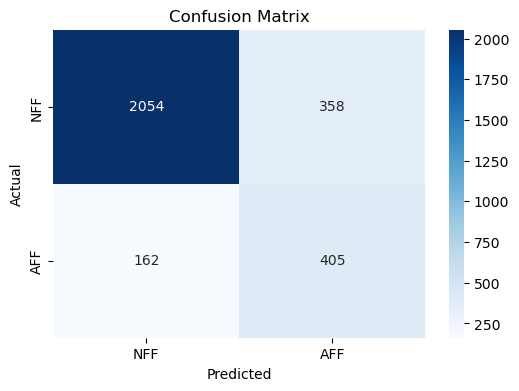

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.85      0.89      2412
           1       0.53      0.71      0.61       567

    accuracy                           0.83      2979
   macro avg       0.73      0.78      0.75      2979
weighted avg       0.85      0.83      0.83      2979



{'Test Loss': 0.615,
 'Total Acc': 0.825,
 'nff Acc': 0.852,
 'aff Acc': 0.714,
 'AUC': 0.783,
 'MCC': 0.509,
 'F1 Score': 0.609}

In [4]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import vgg19, VGG19_Weights

torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')

# models from job, 50% freezed
class CustomNet(nn.Module):
    def __init__(self, num_classes=2, freeze_percentage=0.5):
        super(CustomNet, self).__init__()

        # Load the pre-trained VGG19 model
        vgg19_model = models.vgg19(weights=VGG19_Weights.DEFAULT)

        # Extract features (all layers except the classifier)
        self.features = nn.Sequential(*list(vgg19_model.features.children()))

        # Calculate the index where to split the layers
        total_layers = len(list(self.features.children()))
        split_idx = int(total_layers * freeze_percentage)

        # Split the layers into groups for freezing and non-freezing
        children = list(self.features.children())
        self.frozen_features = nn.Sequential(*children[:split_idx])
        self.unfrozen_features = nn.Sequential(*children[split_idx:])

        # Freeze layers in self.frozen_features
        for param in self.frozen_features.parameters():
            param.requires_grad = False

        # Define the final fully connected layer
        in_features = vgg19_model.classifier[0].in_features
        self.classifier = nn.Linear(in_features, num_classes)  # VGG19's last feature map has 512 channels

    def forward(self, x):
        x = self.frozen_features(x)
        x = self.unfrozen_features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# create net
model = CustomNet(num_classes=2)  # num_classes 2

# checkpoint
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# vgg19
global_path = '/local/data1/honzh073/data/suzuki.ad.liu.se/(fedavg)vgg19_data3/workspace/app_server/FL_global_model.pt'


checkpoint = torch.load(global_path, map_location=device)

# modify checkpoint keys，match model
# load model weights
state_dict = checkpoint['model']
modified_state_dict = {}
for key, value in state_dict.items():
    # modify key names，match model layers
    new_key = key.replace("model.", "")
    modified_state_dict[new_key] = value

# load weights to model
model.load_state_dict(modified_state_dict)
model = model.to(device)
model.eval()


# 加载测试数据集
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_csv_file = "/local/data1/honzh073/local_repository/FL/code/6_test_global_model/csv_files/test_data.csv"

test_dataset = CustomDataset(csv_file=test_csv_file, transform=test_transform)
test_model(model, test_dataset)

# ResNet 50


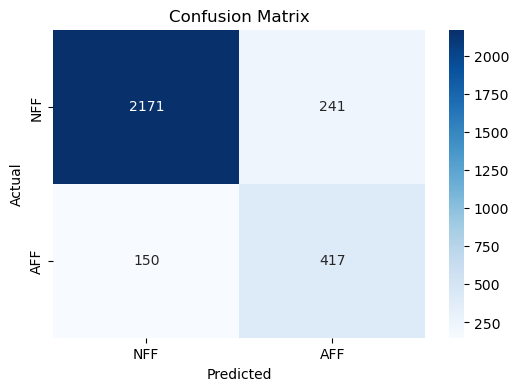

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      2412
           1       0.63      0.74      0.68       567

    accuracy                           0.87      2979
   macro avg       0.78      0.82      0.80      2979
weighted avg       0.88      0.87      0.87      2979



{'Test Loss': 0.423,
 'Total Acc': 0.869,
 'nff Acc': 0.9,
 'aff Acc': 0.735,
 'AUC': 0.818,
 'MCC': 0.601,
 'F1 Score': 0.681}

In [5]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import resnet101, ResNet101_Weights
from torchvision.models import resnet50, ResNet50_Weights

torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')

class CustomNet(nn.Module):
    def __init__(self, num_classes=2, freeze_percentage=0.5):
        super(CustomNet, self).__init__()

        self.features = models.resnet50(weights=ResNet50_Weights.DEFAULT)

        # Calculate the index where to split the layerszh
        total_layers = len(list(self.features.children()))
        split_idx = int(total_layers * freeze_percentage)

        # Split the layers into groups for freezing and non-freezing
        children = list(self.features.children())
        self.frozen_features = nn.Sequential(*children[:split_idx])
        self.unfrozen_features = nn.Sequential(*children[split_idx:-1])  # Exclude the last layer

        # Freeze layers in self.frozen_features
        for param in self.frozen_features.parameters():
            param.requires_grad = False

        # Define the final fully connected layer
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.frozen_features(x)
        x = self.unfrozen_features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
# create net
model = CustomNet(num_classes=2)  # num_classes 2

# checkpoint
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

global_path = '/local/data1/honzh073/data/suzuki.ad.liu.se/(fedavg)resnet50_data3/workspace/app_server/FL_global_model.pt'


checkpoint = torch.load(global_path, map_location=device)

# print(checkpoint.keys())

# modify checkpoint keys，match model
# load model weights
state_dict = checkpoint['model']
modified_state_dict = {}
for key, value in state_dict.items():
    # modify key names，match model layers
    new_key = key.replace("model.", "")
    modified_state_dict[new_key] = value

# load weights to model
model.load_state_dict(modified_state_dict)
model = model.to(device)
model.eval()


# 加载测试数据集
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_csv_file = "/local/data1/honzh073/local_repository/FL/code/6_test_global_model/csv_files/test_data.csv"

test_dataset = CustomDataset(csv_file=test_csv_file, transform=test_transform)
test_model(model, test_dataset)

# ResNet 101

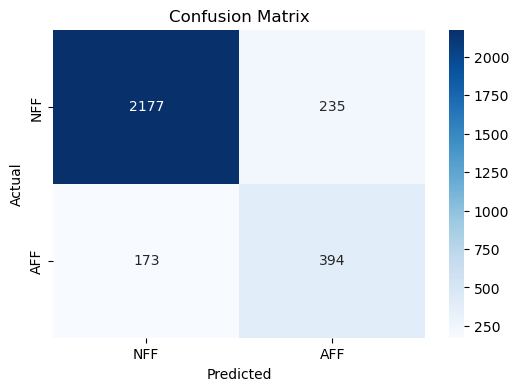

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.90      0.91      2412
           1       0.63      0.69      0.66       567

    accuracy                           0.86      2979
   macro avg       0.78      0.80      0.79      2979
weighted avg       0.87      0.86      0.87      2979



{'Test Loss': 0.507,
 'Total Acc': 0.863,
 'nff Acc': 0.903,
 'aff Acc': 0.695,
 'AUC': 0.799,
 'MCC': 0.575,
 'F1 Score': 0.659}

In [6]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import resnet101, ResNet101_Weights
from torchvision.models import resnet50, ResNet50_Weights

torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')

class CustomNet(nn.Module):
    def __init__(self, num_classes=2, freeze_percentage=0.5):
        super(CustomNet, self).__init__()

        self.features = models.resnet101(weights=ResNet101_Weights.DEFAULT)

        # Calculate the index where to split the layers
        total_layers = len(list(self.features.children()))
        split_idx = int(total_layers * freeze_percentage)

        # Split the layers into groups for freezing and non-freezing
        children = list(self.features.children())
        self.frozen_features = nn.Sequential(*children[:split_idx])
        self.unfrozen_features = nn.Sequential(*children[split_idx:-1])  # Exclude the last layer

        # Freeze layers in self.frozen_features
        for param in self.frozen_features.parameters():
            param.requires_grad = False

        # Define the final fully connected layer
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.frozen_features(x)
        x = self.unfrozen_features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
# create net
model = CustomNet(num_classes=2)  # num_classes 2

# checkpoint
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

global_path = '/local/data1/honzh073/data/suzuki.ad.liu.se/(fedavg)resnet101_data3/workspace/app_server/FL_global_model.pt'




checkpoint = torch.load(global_path, map_location=device)

# print(checkpoint.keys())

# modify checkpoint keys，match model
# load model weights
state_dict = checkpoint['model']
modified_state_dict = {}
for key, value in state_dict.items():
    # modify key names，match model layers
    new_key = key.replace("model.", "")
    modified_state_dict[new_key] = value

# load weights to model
model.load_state_dict(modified_state_dict)
model = model.to(device)
model.eval()

# 加载测试数据集
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_csv_file = "/local/data1/honzh073/local_repository/FL/code/6_test_global_model/csv_files/test_data.csv"

test_dataset = CustomDataset(csv_file=test_csv_file, transform=test_transform)
test_model(model, test_dataset)

# ResNet152

In [7]:
# import torch
# import torch.nn as nn
# import torchvision.models as models
# from torchvision.models import resnet152, ResNet152_Weights

# torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')

# class CustomNet(nn.Module):
#     def __init__(self, num_classes=2, freeze_percentage=0.5):
#         super(CustomNet, self).__init__()

#         self.features = models.resnet152(weights=ResNet152_Weights.DEFAULT)

#         # Calculate the index where to split the layers
#         total_layers = len(list(self.features.children()))
#         split_idx = int(total_layers * freeze_percentage)

#         # Split the layers into groups for freezing and non-freezing
#         children = list(self.features.children())
#         self.frozen_features = nn.Sequential(*children[:split_idx])
#         self.unfrozen_features = nn.Sequential(*children[split_idx:-1])  # Exclude the last layer

#         # Freeze layers in self.frozen_features
#         for param in self.frozen_features.parameters():
#             param.requires_grad = False

#         # Define the final fully connected layer
#         self.fc = nn.Linear(2048, num_classes)

#     def forward(self, x):
#         x = self.frozen_features(x)
#         x = self.unfrozen_features(x)
#         x = x.view(x.size(0), -1)
#         x = self.fc(x)
#         return x
    
# # create net
# model = CustomNet(num_classes=2)  # num_classes 2

# # checkpoint
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# # resnet152_freeze_Adam_200R_1E
# global_path = '/local/data1/honzh073/data/suzuki.ad.liu.se/4130d3d0-e84b-4973-b303-ba3972822f6b/app_server/FL_global_model.pt'
# checkpoint = torch.load(global_path, map_location=device)

# # print(checkpoint.keys())

# # modify checkpoint keys，match model
# # load model weights
# state_dict = checkpoint['model']
# modified_state_dict = {}
# for key, value in state_dict.items():
#     # modify key names，match model layers
#     new_key = key.replace("model.", "")
#     modified_state_dict[new_key] = value

# # load weights to model
# model.load_state_dict(modified_state_dict)
# model = model.to(device)
# model.eval()

# # 加载测试数据集
# test_transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# test_csv_file = "/local/data1/honzh073/local_repository/FL/code/6_test_global_model/csv_files/test_data.csv"

# test_dataset = CustomDataset(csv_file=test_csv_file, transform=test_transform)
# test_model(model, test_dataset)


# DenseNet 161


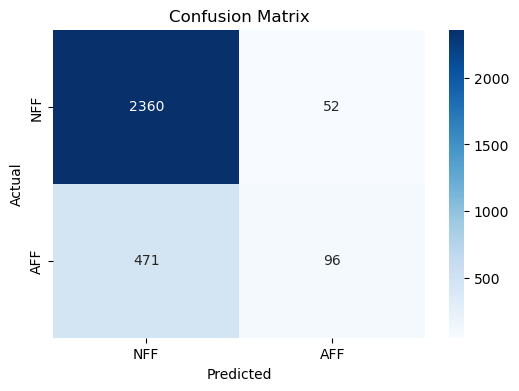

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.98      0.90      2412
           1       0.65      0.17      0.27       567

    accuracy                           0.82      2979
   macro avg       0.74      0.57      0.58      2979
weighted avg       0.80      0.82      0.78      2979



{'Test Loss': 0.433,
 'Total Acc': 0.824,
 'nff Acc': 0.978,
 'aff Acc': 0.169,
 'AUC': 0.574,
 'MCC': 0.267,
 'F1 Score': 0.269}

In [8]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import densenet161, DenseNet161_Weights

torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')

class CustomNet(nn.Module):
    def __init__(self, num_classes=2, freeze_percentage=0.5):
        super(CustomNet, self).__init__()

        self.features = models.densenet161(weights=DenseNet161_Weights.DEFAULT)

        # Calculate the index where to split the layers
        total_layers = len(list(self.features.children()))
        split_idx = int(total_layers * freeze_percentage)

        # Split the layers into groups for freezing and non-freezing
        children = list(self.features.children())
        self.frozen_features = nn.Sequential(*children[:split_idx])
        self.unfrozen_features = nn.Sequential(*children[split_idx:-1])  # Exclude the last layer

        # Freeze layers in self.frozen_features
        for param in self.frozen_features.parameters():
            param.requires_grad = False

        # Define the final fully connected layer
        self.fc = nn.Linear(2208, num_classes)  # DenseNet-161 has 2208 output features

    def forward(self, x):
        x = self.frozen_features(x)
        x = self.unfrozen_features(x)
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))  # Global average pooling
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


# create net
model = CustomNet(num_classes=2)  # num_classes 2

# checkpoint
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# resnet101_freeze_Adam_200R_1E
global_path = '/local/data1/honzh073/data/suzuki.ad.liu.se/9f29e22d-0290-4f02-aaf3-aa83ae05d9e5/app_server/FL_global_model.pt'

checkpoint = torch.load(global_path, map_location=device)

# print(checkpoint.keys())

# modify checkpoint keys，match model
# load model weights
state_dict = checkpoint['model']
modified_state_dict = {}
for key, value in state_dict.items():
    # modify key names，match model layers
    new_key = key.replace("model.", "")
    modified_state_dict[new_key] = value

# load weights to model
model.load_state_dict(modified_state_dict)
model = model.to(device)
model.eval()

# 加载测试数据集
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_csv_file = "/local/data1/honzh073/local_repository/FL/code/6_test_global_model/csv_files/test_data.csv"

test_dataset = CustomDataset(csv_file=test_csv_file, transform=test_transform)
test_model(model, test_dataset)